<a href="https://colab.research.google.com/github/kckDeepak/selfie_eye_extraction/blob/main/selfie_eye_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1: Imports & Setup

In [11]:
pip install mediapipe

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp  # For face mesh landmarks

In [13]:
# Paths (reuse from Task 1 or set new)
INPUT_DIR = './input_images/'  # Or './output_degraded/combined/' for selfie-sim
OUTPUT_DIR = './output_eyes/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [14]:
# Subfolders: left/right eyes
EYE_DIRS = {
    'left': OUTPUT_DIR + 'left/',
    'right': OUTPUT_DIR + 'right/'
}
for subdir in EYE_DIRS.values():
    os.makedirs(subdir, exist_ok=True)

In [15]:
# MediaPipe setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,  # For batch images (not video)
    max_num_faces=1,         # Assume one face per selfie
    refine_landmarks=True,   # Better eye/iris detail
    min_detection_confidence=0.5
)

mp_drawing = mp.solutions.drawing_utils  # For optional landmark viz

print(f"MediaPipe ready. Processing images from {INPUT_DIR}")

MediaPipe ready. Processing images from ./input_images/


Cell 2: Load Images (Reuse or Reload)

In [16]:
def load_images(dir_path, target_size=(512, 512)):
    images = []
    filenames = []
    for filename in sorted(os.listdir(dir_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(dir_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
                filenames.append(filename)
    return images, filenames

input_images, filenames = load_images(INPUT_DIR)  # 'input_images' to avoid overwriting originals
print(f"Loaded {len(input_images)} images for eye extraction.")

Loaded 10 images for eye extraction.


Cell 3: Define Eye Extraction Function

In [17]:
# Core function: Detect landmarks -> Extract eye crops
def extract_eye_regions(img, side='both', zoom_factor=1.8, padding=30):
    """
    side: 'left', 'right', or 'both'
    zoom_factor: Scale crop size (1.5-2.0 for tighter zoom)
    padding: Extra pixels around bbox for context (lids, etc.)
    Returns: Dict of {'left': cropped_img, 'right': cropped_img} or single
    """
    h, w = img.shape[:2]
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_img)

    if not results.multi_face_landmarks:
        print("No face detected!")
        return None

    landmarks = results.multi_face_landmarks[0].landmark

    # Eye landmark indices (MediaPipe Face Mesh)
    LEFT_EYE_INDICES = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]  # Full outline
    RIGHT_EYE_INDICES = [362, 382, 381, 380, 374, 373, 390, 249, 263, 466, 388, 387, 386, 385, 384, 398]  # Full outline

    eye_coords = {}

    if side in ['left', 'both']:
        left_points = np.array([(landmarks[i].x * w, landmarks[i].y * h) for i in LEFT_EYE_INDICES])
        min_x_l, min_y_l = np.min(left_points, axis=0)
        max_x_l, max_y_l = np.max(left_points, axis=0)
        # Bbox with padding
        x1_l, y1_l = max(0, int(min_x_l - padding)), max(0, int(min_y_l - padding))
        x2_l, y2_l = min(w, int(max_x_l + padding)), min(h, int(max_y_l + padding))
        # Zoom: Expand bbox proportionally
        center_x_l, center_y_l = (x1_l + x2_l) // 2, (y1_l + y2_l) // 2
        width_l = x2_l - x1_l
        height_l = y2_l - y1_l
        new_width_l = int(width_l * zoom_factor)
        new_height_l = int(height_l * zoom_factor)
        x1_l = max(0, center_x_l - new_width_l // 2)
        y1_l = max(0, center_y_l - new_height_l // 2)
        x2_l = min(w, center_x_l + new_width_l // 2)
        y2_l = min(h, center_y_l + new_height_l // 2)
        eye_coords['left'] = img[y1_l:y2_l, x1_l:x2_l]

    if side in ['right', 'both']:
        right_points = np.array([(landmarks[i].x * w, landmarks[i].y * h) for i in RIGHT_EYE_INDICES])
        min_x_r, min_y_r = np.min(right_points, axis=0)
        max_x_r, max_y_r = np.max(right_points, axis=0)
        x1_r, y1_r = max(0, int(min_x_r - padding)), max(0, int(min_y_r - padding))
        x2_r, y2_r = min(w, int(max_x_r + padding)), min(h, int(max_y_r + padding))
        center_x_r, center_y_r = (x1_r + x2_r) // 2, (y1_r + y2_r) // 2
        width_r = x2_r - x1_r
        height_r = y2_r - y1_r
        new_width_r = int(width_r * zoom_factor)
        new_height_r = int(height_r * zoom_factor)
        x1_r = max(0, center_x_r - new_width_r // 2)
        y1_r = max(0, center_y_r - new_height_r // 2)
        x2_r = min(w, center_x_r + new_width_r // 2)
        y2_r = min(h, center_y_r + new_height_r // 2)
        eye_coords['right'] = img[y1_r:y2_r, x1_r:x2_r]

    return eye_coords

# Optional: Draw landmarks on original for debugging
def draw_landmarks(img, results):
    annotated = img.copy()
    mp_drawing.draw_landmarks(annotated, results.multi_face_landmarks[0], mp_face_mesh.FACEMESH_CONTOURS)
    return annotated

Cell 4: Batch Process Images & Save Crops

In [18]:
# Process all images
for i, (img, fname) in enumerate(zip(input_images, filenames)):
    base_name = os.path.splitext(fname)[0]

    # Extract eyes
    eyes = extract_eye_regions(img, side='both', zoom_factor=1.8, padding=25)  # Tune zoom/pad here

    if eyes:
        # Save left/right
        if 'left' in eyes and eyes['left'].size > 0:
            cv2.imwrite(EYE_DIRS['left'] + f'{base_name}_left_zoomed.jpg', eyes['left'])
        if 'right' in eyes and eyes['right'].size > 0:
            cv2.imwrite(EYE_DIRS['right'] + f'{base_name}_right_zoomed.jpg', eyes['right'])

        print(f"Extracted eyes from {fname}: Left {eyes['left'].shape[:2] if 'left' in eyes else 'N/A'}, Right {eyes['right'].shape[:2] if 'right' in eyes else 'N/A'}")
    else:
        print(f"No eyes detected in {fname}")

print(f"Done! Check {len([f for f in os.listdir(EYE_DIRS['left'])])} left / {len([f for f in os.listdir(EYE_DIRS['right']) ])} right crops in {OUTPUT_DIR}")

Extracted eyes from download (10).jpeg: Left (122, 130), Right (116, 134)
Extracted eyes from download (11).jpeg: Left (100, 108), Right (102, 118)
No face detected!
No eyes detected in download (12).jpeg
Extracted eyes from download (6).jpeg: Left (106, 130), Right (120, 132)
Extracted eyes from download (7).jpeg: Left (104, 144), Right (100, 140)
Extracted eyes from download (8).jpeg: Left (116, 144), Right (112, 156)
Extracted eyes from download (9).jpeg: Left (104, 144), Right (102, 134)
Extracted eyes from images (1).jpeg: Left (102, 126), Right (100, 126)
Extracted eyes from images (2).jpeg: Left (104, 156), Right (108, 164)
Extracted eyes from images.jpeg: Left (104, 144), Right (104, 166)
Done! Check 9 left / 9 right crops in ./output_eyes/


Cell 5: Visualize Before/After for Sample Images

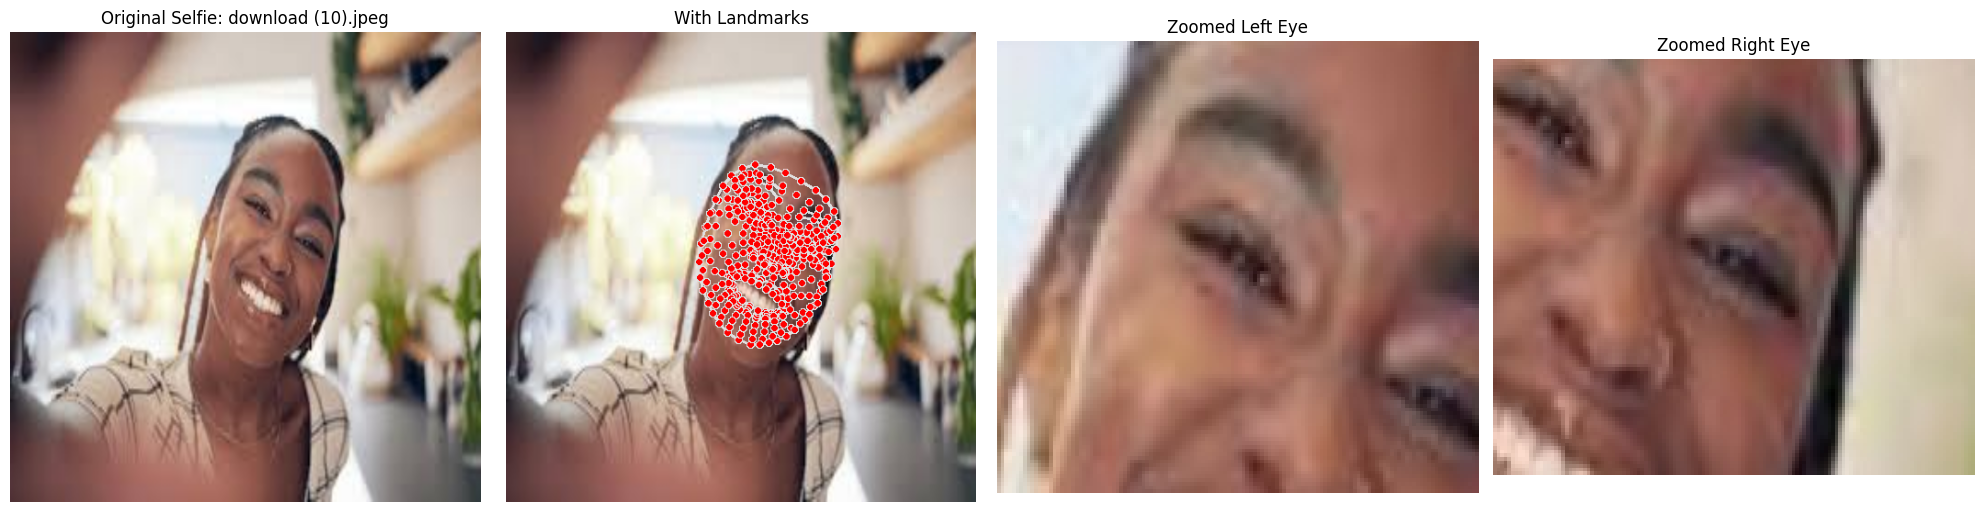

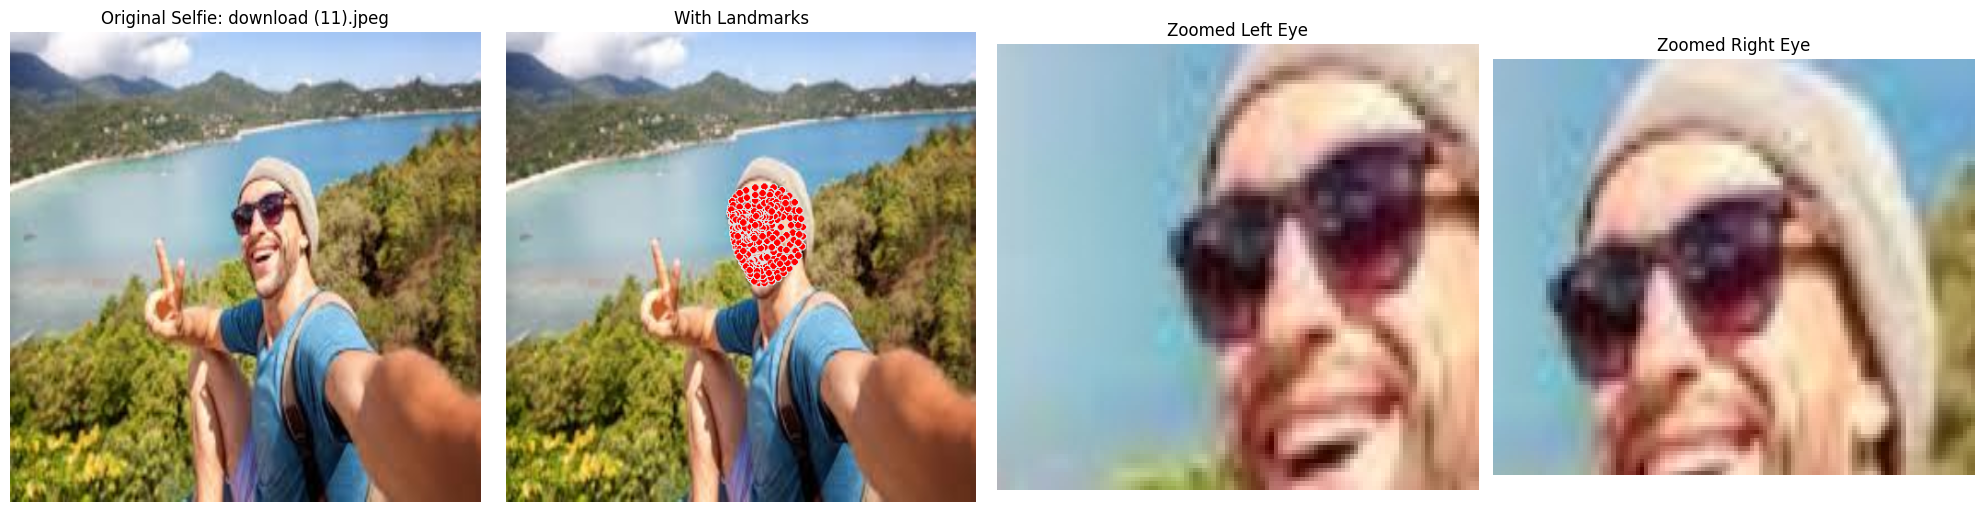

In [19]:
# Viz first 2 images: Original + annotated + cropped eyes
for i in range(min(2, len(input_images))):
    img = input_images[i]
    fname = filenames[i]
    base_name = os.path.splitext(fname)[0]

    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_img)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original
    axes[0].imshow(rgb_img)
    axes[0].set_title(f'Original Selfie: {fname}')
    axes[0].axis('off')

    # Annotated landmarks
    if results.multi_face_landmarks:
        annotated = draw_landmarks(img, results)
        axes[1].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        axes[1].set_title('With Landmarks')
        axes[1].axis('off')

    # Load & show cropped eyes
    left_crop_path = EYE_DIRS['left'] + f'{base_name}_left_zoomed.jpg'
    right_crop_path = EYE_DIRS['right'] + f'{base_name}_right_zoomed.jpg'

    if os.path.exists(left_crop_path):
        left_crop = cv2.imread(left_crop_path)
        axes[2].imshow(cv2.cvtColor(left_crop, cv2.COLOR_BGR2RGB))
        axes[2].set_title('Zoomed Left Eye')
        axes[2].axis('off')

    if os.path.exists(right_crop_path):
        right_crop = cv2.imread(right_crop_path)
        axes[3].imshow(cv2.cvtColor(right_crop, cv2.COLOR_BGR2RGB))
        axes[3].set_title('Zoomed Right Eye')
        axes[3].axis('off')

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + f'extraction_viz_{base_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

Cell 6: Advanced Tweaks (Optional: Alignment & Batch on Degraded)

In [20]:
# Bonus: Simple alignment (affine warp to make eye horizontal—helps for modeling)
def align_eye_crop(crop_img, landmarks_subset):
    """Straighten eye using 2-3 points (e.g., eye corners). Basic example."""
    if len(landmarks_subset) < 2:
        return crop_img
    pts1 = np.float32(landmarks_subset[:3])  # Source points (e.g., from full landmarks)
    pts2 = np.float32([[50, 50], [150, 50], [100, 100]])  # Target: horizontal
    M = cv2.getAffineTransform(pts1, pts2)
    aligned = cv2.warpAffine(crop_img, M, (crop_img.shape[1], crop_img.shape[0]))
    return aligned

# Example: Apply to a left crop (pass relevant landmark coords)
# In Cell 4 loop, after cropping: eyes['left'] = align_eye_crop(eyes['left'], left_points[:3])

# For degraded inputs: Set INPUT_DIR = './output_degraded/combined/' and re-run Cells 2-4
print("Pro tip: For gaze robustness, test on up/down images—MediaPipe handles ~85% tilt.")

Pro tip: For gaze robustness, test on up/down images—MediaPipe handles ~85% tilt.


In [21]:
from google.colab import files
import shutil

In [23]:
shutil.make_archive("output_eyes", 'zip', "output_eyes")

'/content/output_eyes.zip'

In [25]:
files.download("output_eyes.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>